In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar los archivos CSV
sellers = pd.read_csv('sellers.csv')
reviews = pd.read_csv('reviews.csv')
products = pd.read_csv('products.csv')
orders = pd.read_csv('orders.csv')
order_payments = pd.read_csv('order_payments.csv')
order_items = pd.read_csv('order_items.csv')
customers = pd.read_csv('customers.csv')

In [3]:
# Unir los DataFrames
df = pd.merge(orders, customers, on='customer_id')
df = pd.merge(df, order_payments, on='order_id')
df = pd.merge(df, order_items, on='order_id')
df = pd.merge(df, reviews, on='order_id', how='left')

# Mostrar las primeras filas del DataFrame
print(df.head())

                           order_id                       customer_id  \
0  1582d3d1c7a4c1fd7b5857c7e6c084bb  c1d75069901ff3b203405a36de0c653b   
1  1582d3d1c7a4c1fd7b5857c7e6c084bb  c1d75069901ff3b203405a36de0c653b   
2  1582d3d1c7a4c1fd7b5857c7e6c084bb  c1d75069901ff3b203405a36de0c653b   
3  770a0411b7850b3d8f8c55cd41316eb9  d12b894fe079585668a12171ef6d3a9c   
4  64cafa9458e5376e77efcce3c095e541  1df65b523d72a0bb1e1716380fb5cf81   

      status   purchase_timestamp          approved_at delivered_courier_date  \
0  delivered  2022-10-02 10:56:33  2022-10-02 11:07:15    2022-10-04 19:55:00   
1  delivered  2022-10-02 10:56:33  2022-10-02 11:07:15    2022-10-04 19:55:00   
2  delivered  2022-10-02 10:56:33  2022-10-02 11:07:15    2022-10-04 19:55:00   
3  delivered  2023-07-24 20:41:37  2023-07-26 03:24:27    2023-07-26 14:31:00   
4  delivered  2023-08-08 08:38:49  2023-08-08 08:55:23    2023-08-08 13:50:00   

  delivered_customer_date estimated_delivery_date  \
0     2022-10-10 21:2

In [4]:
# Eliminar duplicados
df.drop_duplicates(inplace=True)

# Rellenar valores nulos
df.fillna({
    'review_id': 'no_review',
    'score': 0,
    'has_comment': 0,
    'review_creation_date': pd.Timestamp.now(),
    'review_answer_timestamp': pd.Timestamp.now()
}, inplace=True)

# Rellenar valores nulos en columnas numéricas y categóricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# Convertir columnas a tipo datetime
df['purchase_timestamp'] = pd.to_datetime(df['purchase_timestamp'])
df['approved_at'] = pd.to_datetime(df['approved_at'])
df['delivered_courier_date'] = pd.to_datetime(df['delivered_courier_date'])
df['delivered_customer_date'] = pd.to_datetime(df['delivered_customer_date'])
df['estimated_delivery_date'] = pd.to_datetime(df['estimated_delivery_date'])
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'])
df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp'])

# Corregir tipo de dato para la columna 'score'
df['score'] = df['score'].replace('s', 5).astype(float)

# Eliminar columnas no necesarias
columns_to_drop = ['postal_code', 'shipping_limit_date', 'freight_value']
df.drop(columns=columns_to_drop, inplace=True)

In [5]:
customer_features = df.groupby('customer_id').agg({
    'amount': 'sum',  # Total Gastado
    'order_id': 'count',  # Frecuencia de Compra
    'price': 'mean',  # Valor Medio de Compra
    'review_id': 'count',  # Número de Reseñas
    'score': 'mean'  # Puntuación Media de Reseñas
}).rename(columns={
    'amount': 'total_spent',
    'order_id': 'purchase_frequency',
    'price': 'average_order_value',
    'review_id': 'num_reviews',
    'score': 'avg_review_score'
})

scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features)
customer_df = pd.DataFrame(customer_features_scaled, columns=customer_features.columns, index=customer_features.index)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                                  total_spent  purchase_frequency  \
customer_id                                                         
00003a19b38e4e3ad8ec20246517646f    -0.003186           -0.182796   
00008d3f597f55ff320cdebaff0a6c93    -0.003177            3.823768   
0000d80011d72fb4a403400918d26093    -0.003183           -0.182796   
0002972a13a3e29bede5fc2efdf88f76    -0.003166           -0.182796   
0002aaa03c477e93b8d6a1d5958bbcbc    -0.003182           -0.182796   

                                  average_order_value  num_reviews  \
customer_id                                                          
00003a19b38e4e3ad8ec20246517646f            -0.262018    -0.182796   
00008d3f597f55ff320cdebaff0a6c93            -0.492744     3.823768   
0000d80011d72fb4a403400918d26093             0.052132    -0.182796   
0002972a13a3e29bede5fc2efdf88f76             3.003052    -0.182796   
0002aaa03c477e93b8d6a1d5958bbcbc             0.125905    -0.182796   

                         

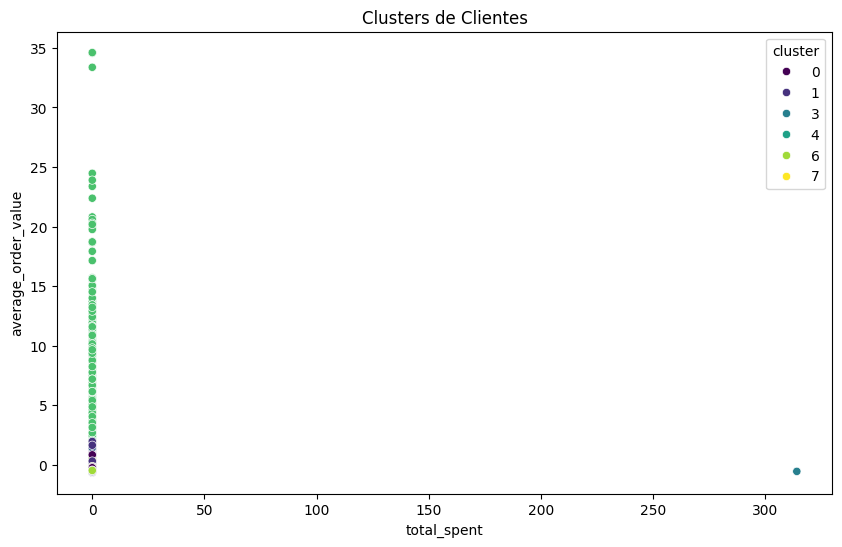

In [7]:
# Entrenar el modelo K-Means
kmeans = KMeans(n_clusters=8, random_state=42)
clusters = kmeans.fit_predict(customer_df)

# Añadir los clusters al DataFrame original de características
customer_df['cluster'] = clusters

# Mostrar las primeras filas del DataFrame con los clusters añadidos
print(customer_df.head())

# Visualización de los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_df, x='total_spent', y='average_order_value', hue='cluster', palette='viridis')
plt.title('Clusters de Clientes')
plt.show()